Name: Tran Thai Duc Hieu  
4-digit code: 8f95  
Email: t.tran@oth-aw.de  

# Used source
Used source is described in **used_source.ipynb**

# 4. Data quality check

## Walking data

In [32]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

FILE_PATH = 'data_record/data.csv'

def loadData(file_path):
    data = np.loadtxt(file_path, delimiter=',', skiprows=1)    
    return data


In [41]:
walking_data = loadData(FILE_PATH)
walking_data[:, 0] = walking_data[:, 0] - walking_data[0, 0]

timestamp = walking_data[:,0]

# Calculate the time difference between each sample
d = timestamp[1:] - timestamp[:-1]
time_diff = pd.DataFrame(d, columns=['time_diff'])
time_diff.describe()

,time_diff
count,6337.000000
mean,20.327915
std,3.439424
min,11.000000
25%,17.000000
50%,21.000000
75%,21.000000
max,37.000000


Unique sampling intervals:
 [11. 12. 13. 14. 15. 16. 17. 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28.
 29. 30. 31. 32. 33. 34. 35. 36. 37.]
Counts of unique sampling intervals:
 [   9   45   70   70  104  267 1083  300  322  626 1937  416  204  126
   96  380  114   38   27   28   26   29   11    1    2    5    1]
---------------------------------
Intervals values that appear more than 100 times:
 [15. 16. 17. 18. 19. 20. 21. 22. 23. 24. 26. 27.]
Counts of most frequent sampling intervals:
 [ 104  267 1083  300  322  626 1937  416  204  126  380  114]


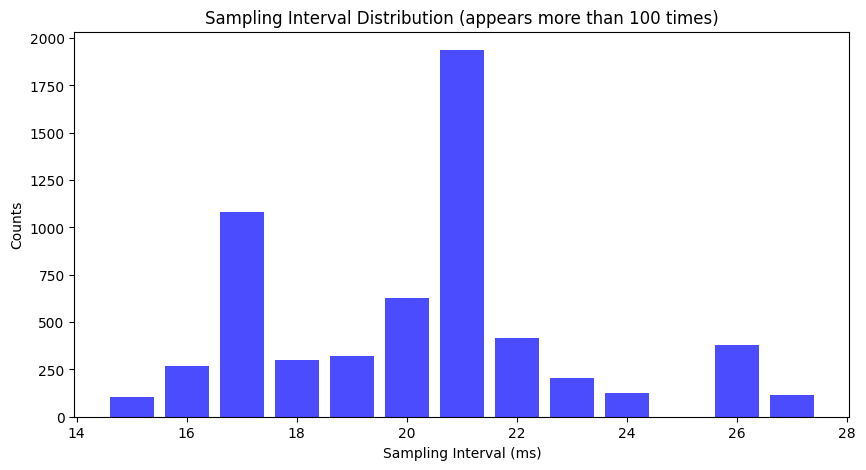

In [3]:
values, counts = np.unique(d, return_counts=True)
print('Unique sampling intervals:\n',values)
print('Counts of unique sampling intervals:\n',counts)
print('---------------------------------')

rate_significant = values[counts > 100]
counts_significant = counts[counts > 100]
print('Intervals values that appear more than 100 times:\n', rate_significant)    
print('Counts of most frequent sampling intervals:\n', counts_significant)

# Plot the sampling intervals   
plt.figure(figsize=(10,5))
plt.bar(rate_significant, counts_significant, color='blue', alpha=0.7)
plt.xlabel('Sampling Interval (ms)')
plt.ylabel('Counts')
plt.title('Sampling Interval Distribution (appears more than 100 times)')
plt.show()



In [4]:
most_frequent_interval_mean = np.mean(rate_significant)
print('Sampling rate (Hz) = 1 / sampling_interval(s)')
print(f'Sampling rate (Hz) = 1 / ({most_frequent_interval_mean} / 1000)')
print(f'Sampling rate (Hz) = {1000 / most_frequent_interval_mean:.2f} Hz')

Sampling rate (Hz) = 1 / sampling_interval(s)
Sampling rate (Hz) = 1 / (20.666666666666668 / 1000)
Sampling rate (Hz) = 48.39 Hz


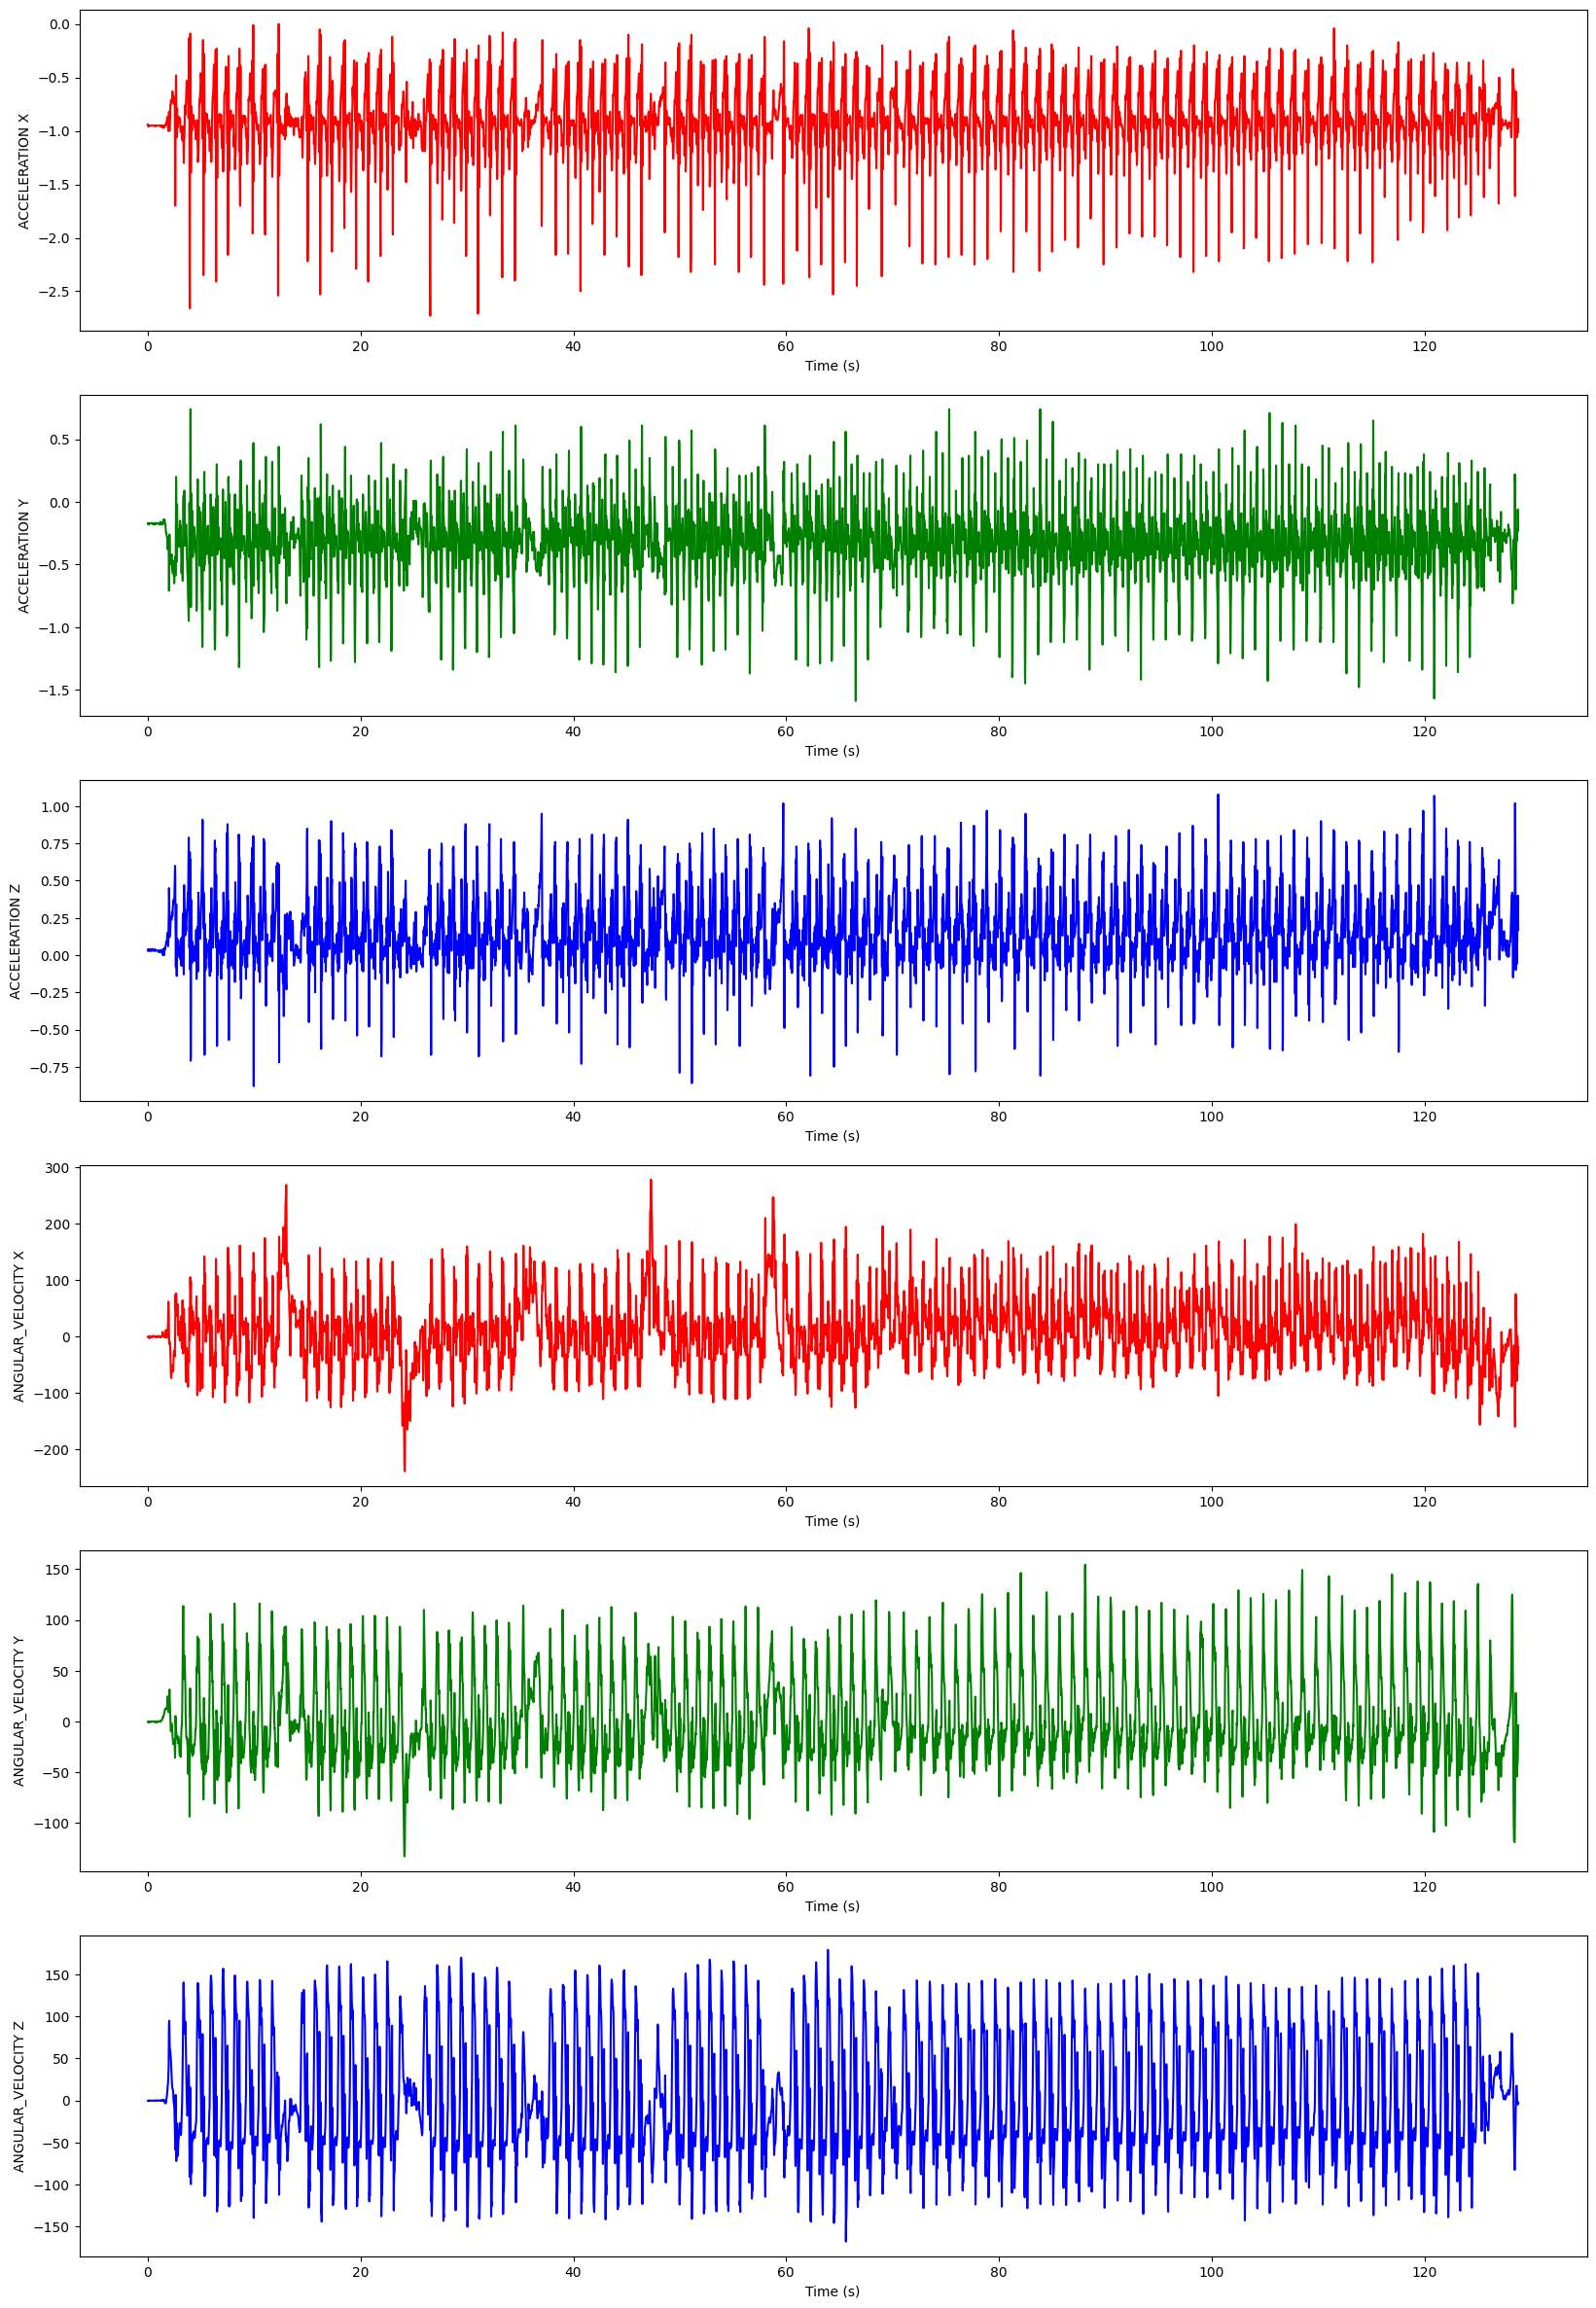

In [5]:
def plotData2(data):
    # Desciption: 
    # Plot all three axes of acceleration, angular velocity
    
    time = data[:, 0] / 1000  # Convert to seconds

    data_dict = {
        'acceleration': data[:, 1:4],
        'angular_velocity': data[:, 4:7],
    }

    plt.figure(figsize=(20, 30))

    row = 1
    for key in ['acceleration', 'angular_velocity']:
        for i, data_axis in enumerate(['x', 'y', 'z']):
            plt.subplot(6, 1, row)
            plt.plot(time, data_dict[key][:, i], color='r' if i == 0 else 'g' if i == 1 else 'b')
            plt.ylabel(key.upper() + ' ' + data_axis.upper())
            plt.xlabel('Time (s)')
            row = row + 1

    plt.show() 

plotData2(walking_data)

## Multiple actions data

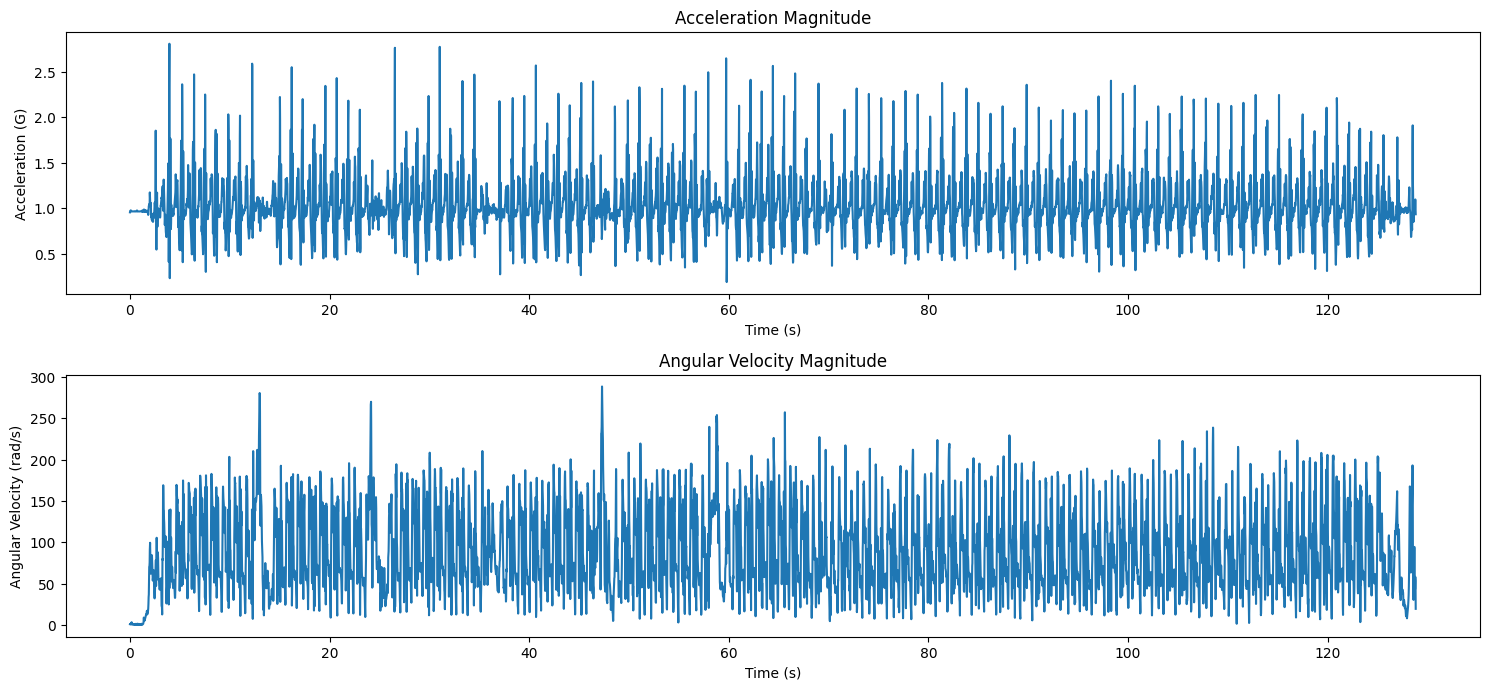

In [8]:
def plotData(data):
    # Desciption: 
    # Plot only the Magnitude of the data

    time = data[:, 0] / 1000  # Convert milliseconds to seconds
    acceleration = data[:, 1:4]  
    angular_velocity = data[:, 4:7]  

    a_abs = np.sqrt(acceleration[:, 0]**2 + acceleration[:, 1]**2 + acceleration[:, 2]**2)
    w_abs = np.sqrt(angular_velocity[:, 0]**2 + angular_velocity[:, 1]**2 + angular_velocity[:, 2]**2)

    # Plot the data
    plt.figure(figsize=(15, 10))

    # Plot acceleration
    plt.subplot(3, 1, 1)
    plt.plot(time, a_abs)
    plt.title('Acceleration Magnitude')
    plt.xlabel('Time (s)')
    plt.ylabel('Acceleration (G)')

    # Plot angular velocity
    plt.subplot(3, 1, 2)
    plt.plot(time, w_abs)
    plt.title('Angular Velocity Magnitude')
    plt.xlabel('Time (s)')
    plt.ylabel('Angular Velocity (rad/s)')

    plt.tight_layout()
    plt.show()

plotData(walking_data)

# 5. Data analysis

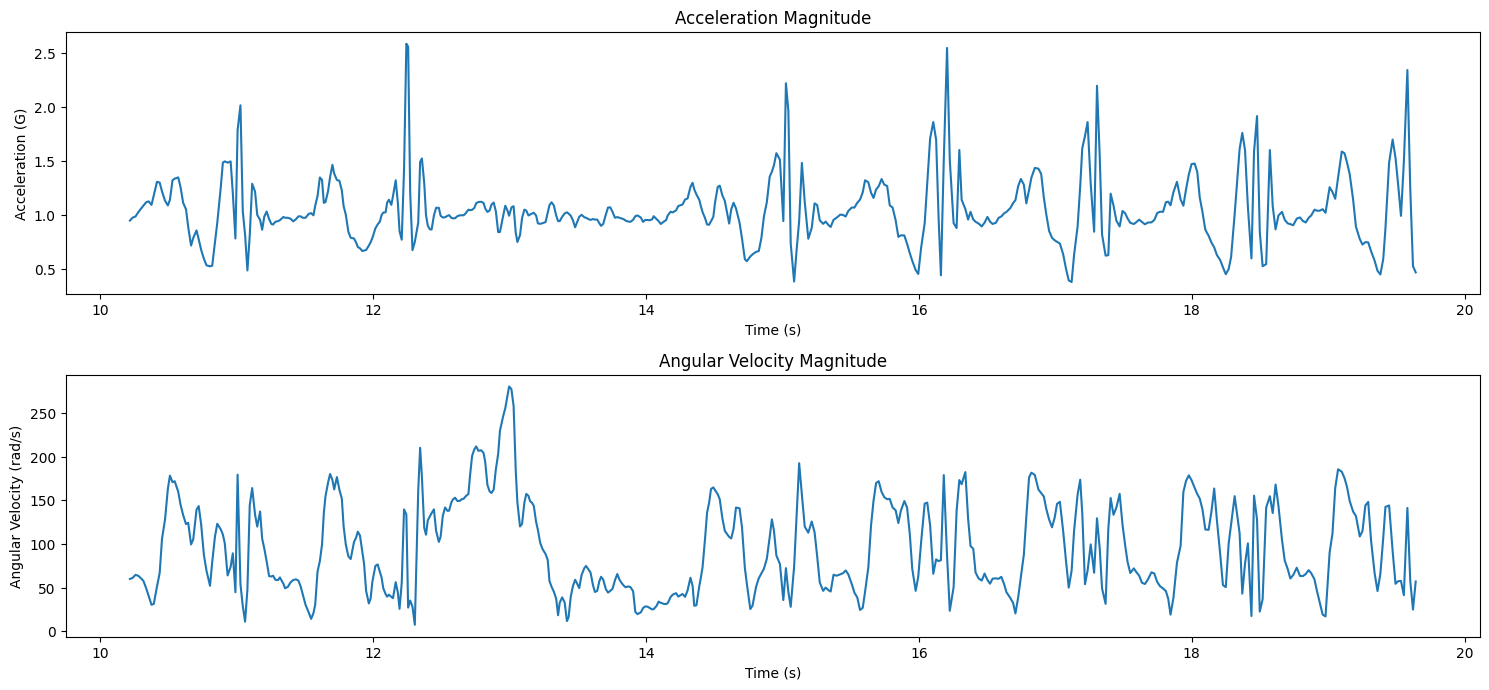

In [12]:
plotData(walking_data[500:1000])

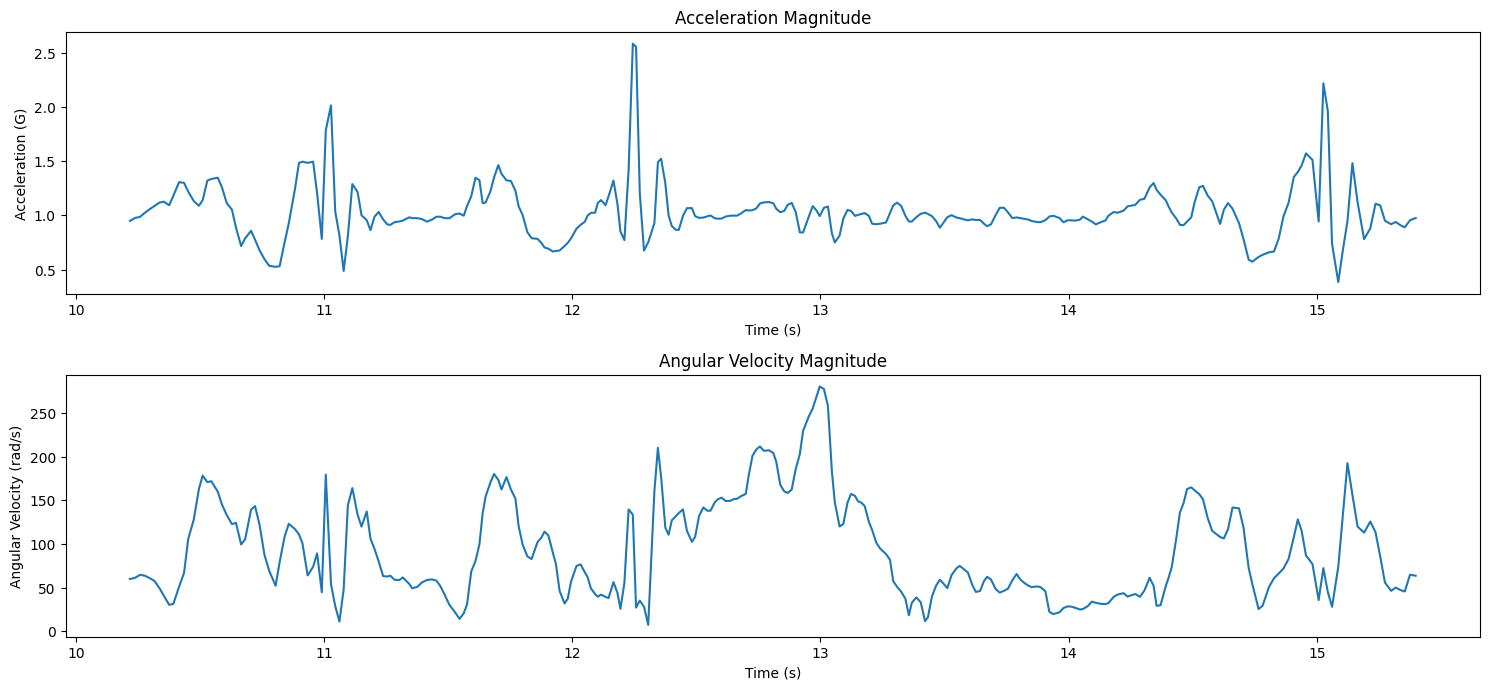

In [14]:
plotData(walking_data[500:800])

# 6. Detection algorithms

## Threshold detection method

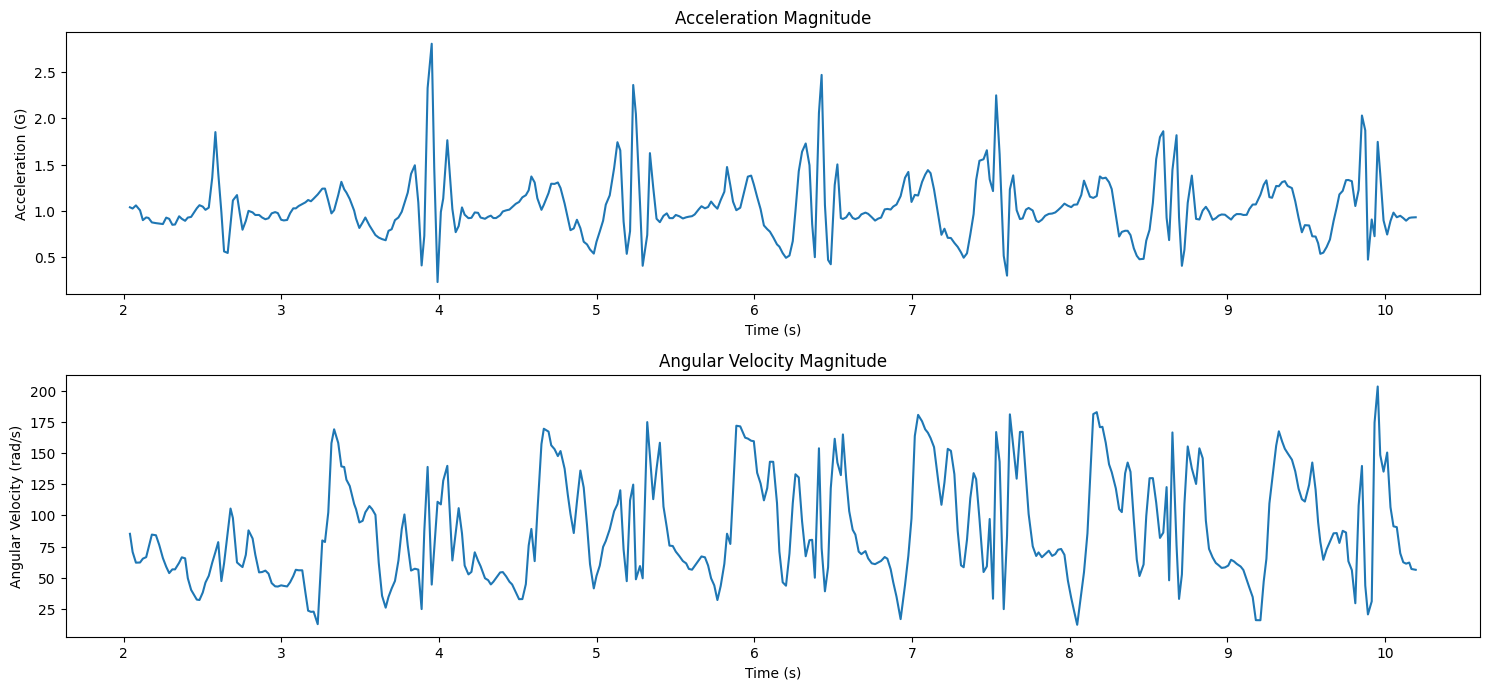

In [28]:
plotData(walking_data[100:500])

Total steps detected: 36


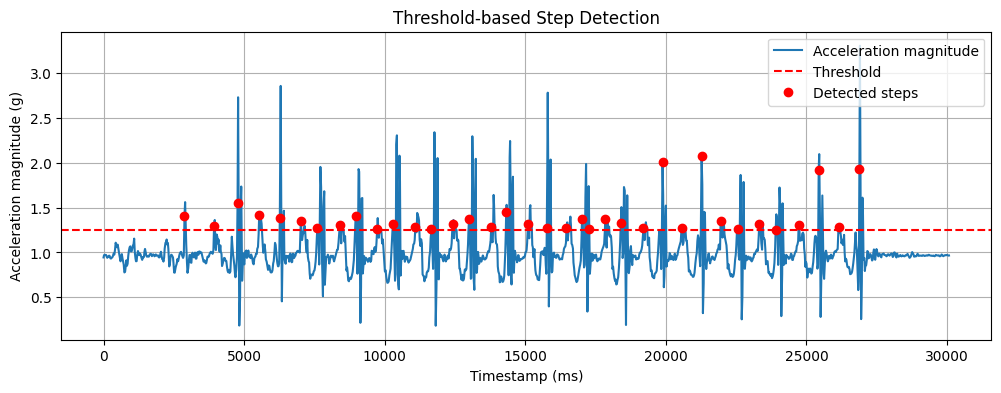

In [ ]:
df_walking = pd.DataFrame(walking_data, columns=['timestamp', 'acc_x', 'acc_y', 'acc_z', 'gyro_x', 'gyro_y', 'gyro_z'])
df_walking['acc_magnitude'] = np.sqrt(df_walking['acc_x']**2 + df_walking['acc_y']**2 + df_walking['acc_z']**2)
df_walking['gyro_magnitude'] = np.sqrt(df_walking['gyro_x']**2 + df_walking['gyro_y']**2 + df_walking['gyro_z']**2)

UPPER_THRESHOLD = 1.25        
STEP_DELAY_MS = 250     
last_step_time = -np.inf
step_count = 0
step_indices = []

for i in range(len(df_walking)):
    a = df_walking['acc_magnitude'].iloc[i]
    t = df_walking['timestamp'].iloc[i]

    if a > UPPER_THRESHOLD and (t - last_step_time) > STEP_DELAY_MS:
        step_count += 1
        last_step_time = t
        step_indices.append(i)

print(f'Total steps detected: {step_count}')

plt.figure(figsize=(12, 4))
plt.plot(df_walking['timestamp'], df_walking['acc_magnitude'], label='Acceleration magnitude')
plt.axhline(y=UPPER_THRESHOLD, color='r', linestyle='--', label='Threshold')

plt.plot(df_walking['timestamp'].iloc[step_indices], df_walking['acc_magnitude'].iloc[step_indices],
         'ro', label='Detected steps')

plt.xlabel("Timestamp (ms)")
plt.ylabel("Acceleration magnitude (g)")
plt.legend()
plt.title("Threshold-based Step Detection")
plt.grid(True)
plt.show()

## Peaks detection method

Number of steps detected: 19


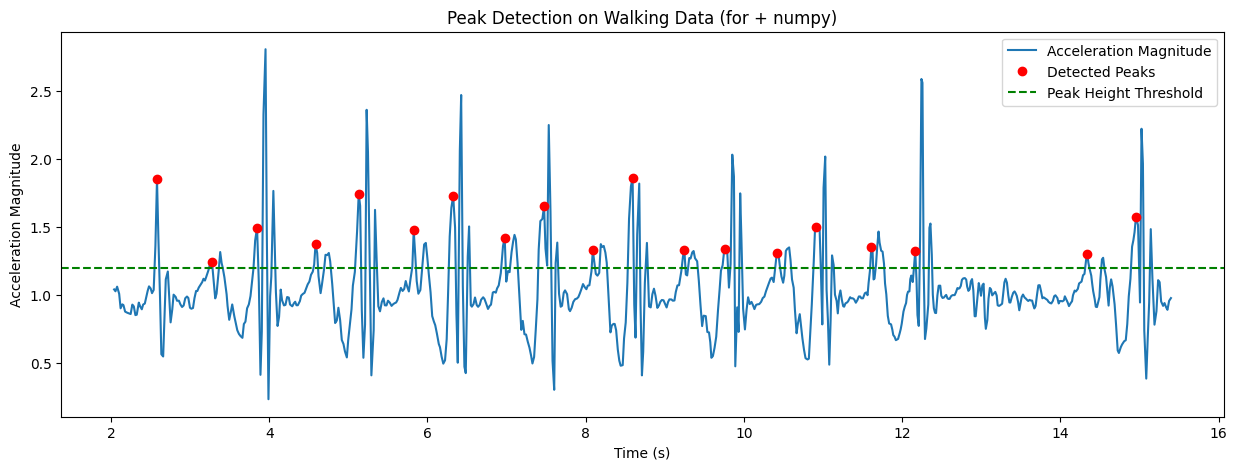

In [ ]:
PEAK_HEIGHT = 1.2  
PEAK_DISTANCE = 10

peaks = []
last_peak_idx = -PEAK_DISTANCE

visualization_data = walking_data[100:800,:-2]
df_walking = pd.DataFrame(visualization_data, columns=['timestamp', 'acc_x', 'acc_y', 'acc_z', 'gyro_x', 'gyro_y', 'gyro_z',])
df_walking['acc_magnitude'] = np.sqrt(df_walking['acc_x']**2 + df_walking['acc_y']**2 + df_walking['acc_z']**2)
df_walking['gyro_magnitude'] = np.sqrt(df_walking['gyro_x']**2 + df_walking['gyro_y']**2 + df_walking['gyro_z']**2)


acc_magnitude = df_walking['acc_magnitude']

for i in range(1, len(acc_magnitude) - 1):
    if (
        acc_magnitude[i] > PEAK_HEIGHT and
        acc_magnitude[i] > acc_magnitude[i - 1] and
        acc_magnitude[i] > acc_magnitude[i + 1] and
        (i - last_peak_idx) >= PEAK_DISTANCE
    ):
        peaks.append(i)
        last_peak_idx = i

print(f"Number of steps detected: {len(peaks)}")

plt.figure(figsize=(15, 5))
plt.plot(visualization_data[:,0] / 1000, acc_magnitude, label='Acceleration Magnitude')
plt.plot(visualization_data[peaks, 0] / 1000, acc_magnitude[peaks], 'ro', label='Detected Peaks')
plt.axhline(PEAK_HEIGHT, color='g', linestyle='--', label='Peak Height Threshold')
plt.xlabel('Time (s)')
plt.ylabel('Acceleration Magnitude')
plt.title('Peak Detection on Walking Data (for + numpy)')
plt.legend()
plt.show()

In [26]:
peaks = np.array(peaks)
start_points = (peaks[:-1] + peaks[1:]) // 2  

print(len(peaks), len(start_points))
print(peaks)
print(start_points)

13 12
[126 161 189 225 251 285 309 341 365 395 420 452 478]
[143 175 207 238 268 297 325 353 380 407 436 465]
